In [6]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry import box
import numpy as np
from scipy.stats import norm
import pandas
#test

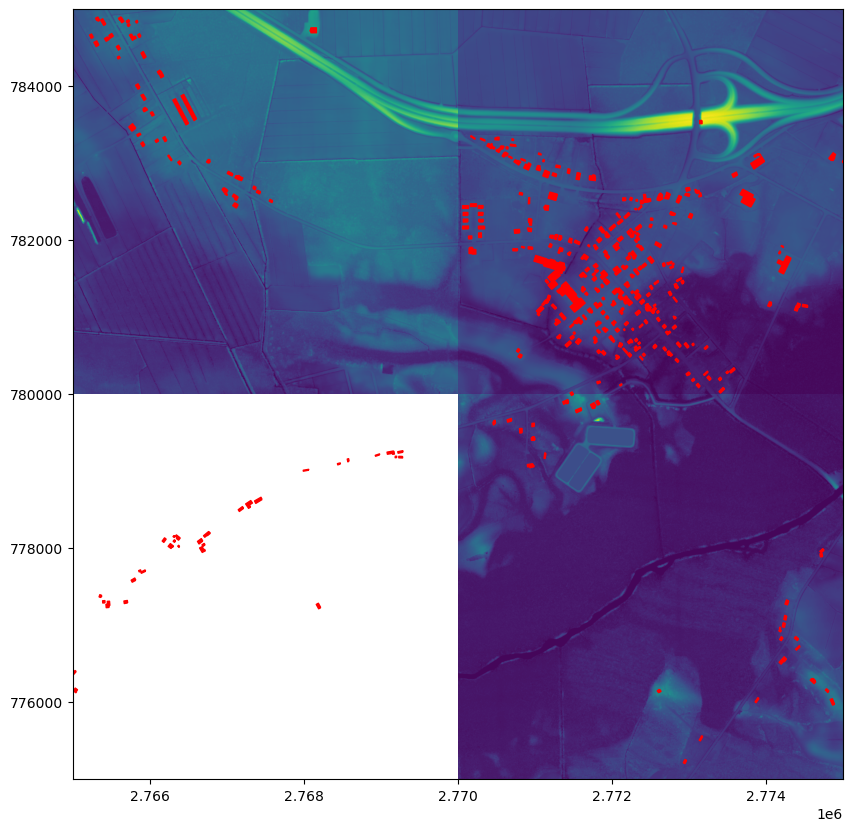

In [2]:
def open_raster(file_path):
    """Open a raster file."""
    return rasterio.open(file_path)

def plot_rasters(raster_paths, ax):
    """Plot multiple raster files."""
    for path in raster_paths:
        raster = open_raster(path)
        show(raster, ax=ax)

def plot_shapefile(shapefile_path, ax):
    """Plot a shapefile."""
    gdf = gpd.read_file(shapefile_path)
    gdf.plot(ax=ax, facecolor='red', edgecolor='red')

# Paths to the rasters and shapefile
raster_paths = [
        '/Users/juntan20216/Desktop/Data+/Creswell/D05_37_20776804_20141231.img',
        '/Users/juntan20216/Desktop/Data+/Creswell/D05_37_20777701_20141231.img',
        '/Users/juntan20216/Desktop/Data+/Creswell/D05_37_20777803_20141231.img'
    ]
shapefile_path = '/Users/juntan20216/Desktop/Washington_2020_Buildings_DRAFT_20240418.gdb.zip'
gdf = gpd.read_file(shapefile_path)
    
# Plot the rasters and shapefile
fig, ax = plt.subplots(figsize=(10, 10))
plot_rasters(raster_paths, ax)
plot_shapefile(shapefile_path, ax)
    
# Zoom into where stuff is, change values as needed
x_min, x_max = 2765000, 2775000  
y_min, y_max = 775000, 785000  
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
    
# Display the plot
plt.show() 

In [3]:
def area_box(minx, miny, maxx, maxy):
    "Create a box to zoom in on an area"
    bbox = box(minx, miny, maxx, maxy)

    # Filter the GeoDataFrame using the bounding box
    gdf_new = gdf[gdf.geometry.intersects(bbox)]

    print(gdf_new.head())

    return gdf_new

minx, miny = 2770000, 780000
maxx, maxy = 2775000, 785000
gdf_cresswell = area_box(minx, miny, maxx, maxy)

      BLDG_ID         PID         BLOCK_ID OCCUP_TYPE BUILD_TYPE YEAR_BUILT  \
43  371873990  7778215990  371879501002017       4245       4040       1930   
44  371873991  7778217618  371879501002017       4230       4030       1975   
45  371873992  7778217618  371879501002017       4230       4030       1975   
46  371873993  7778219506  371879501002017       4000       4040          0   
47   37187447  7778218481  371879501002017       4250       4010       1995   

                          YRBUILTSRC    BLDG_VALUE  \
43  PARCEL DERIVED - HIGH CONFIDENCE  54000.000000   
44  PARCEL DERIVED - HIGH CONFIDENCE  24712.526158   
45  PARCEL DERIVED - HIGH CONFIDENCE  10241.312232   
46                      NOT PROVIDED    500.000000   
47  PARCEL DERIVED - HIGH CONFIDENCE  15038.721212   

                          BLDVAL_SRC   FFE  ... IGNRESMATL_12  EXCLUDE_12  \
43  PARCEL DERIVED - HIGH CONFIDENCE  None  ...            NP         0.0   
44  PARCEL DERIVED - HIGH CONFIDENCE  None  ..

In [4]:
gdf_cresswell.explore()

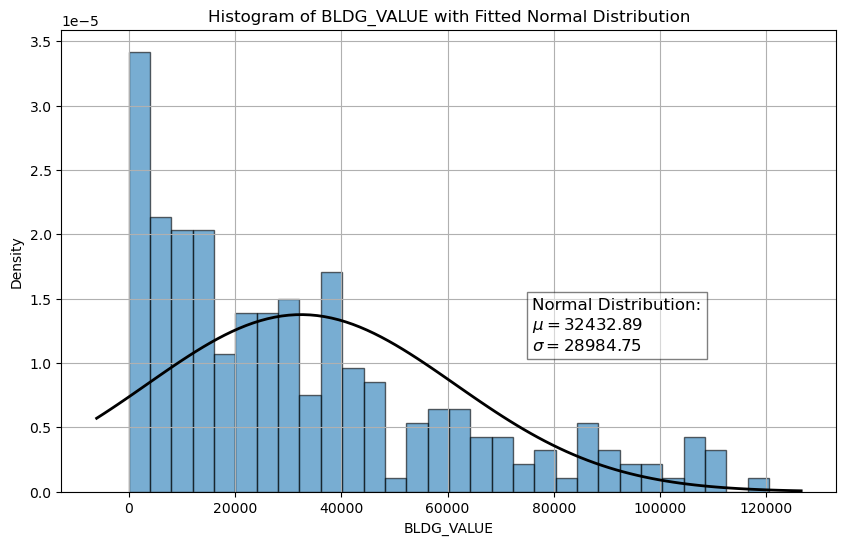

In [8]:
def histogram_plotter(gdf, attribute):
    "creates a histogram of a specific attribute"
    "takes out outliers"
    "adds a best fit distribution"
    Q1 = gdf[attribute].quantile(0.25)
    Q3 = gdf[attribute].quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    filtered_gdf = gdf[(gdf[attribute] >= lower_bound) & (gdf[attribute] <= upper_bound)]

    #fit a distribution to the histogram
    mu, std = norm.fit(filtered_gdf[attribute])

    # Plotting the histogram for the population column without outliers
    plt.figure(figsize=(10, 6))
    # Plot the histogram
    count, bins, ignored = plt.hist(filtered_gdf[attribute], bins=30, density=True, edgecolor='black', alpha=0.6)

    # Plot the fitted normal distribution curve
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)

    # Add titles and labels
    plt.title(f'Histogram of {attribute} with Fitted Normal Distribution')
    plt.xlabel(attribute)
    plt.ylabel('Density')
    plt.grid(True)

    # Add the equation and parameters as text on the plot
    equation_text = f'Normal Distribution:\n$\mu = {mu:.2f}$\n$\sigma = {std:.2f}$'
    plt.text(xmax * 0.6, max(p) * 0.8, equation_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

attribute = 'BLDG_VALUE'
histogram_plotter(gdf_cresswell, attribute)

   example_attribute
0       58281.572211
1       51405.131365
2       44425.557449
3        4573.314937
4       68447.971764


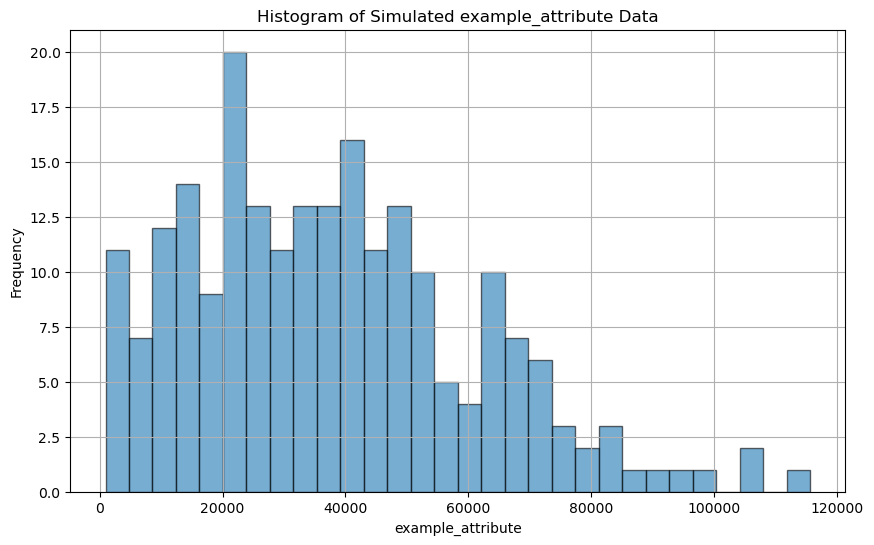

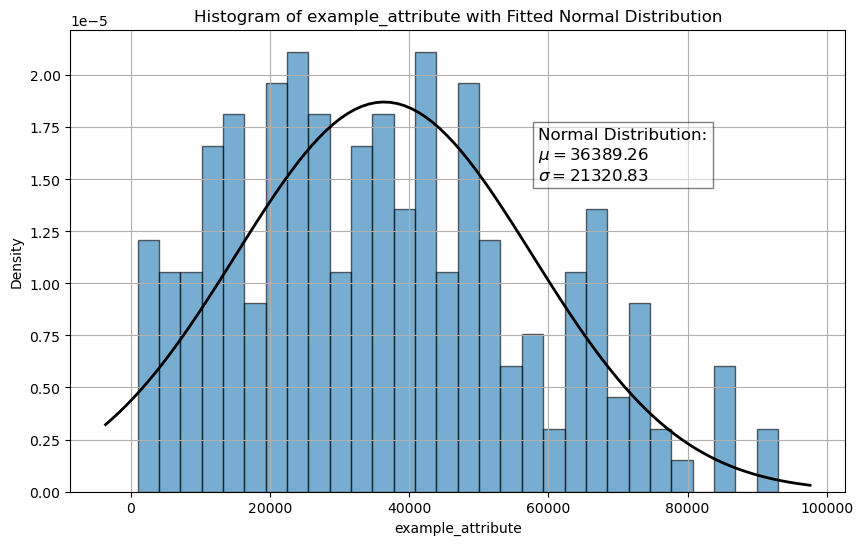

In [9]:
def generate_simulated_data(mu, std, num_points=250):
    """
    Generate simulated data points using a normal distribution.

    Parameters:
    mu (float): Mean of the distribution.
    std (float): Standard deviation of the distribution.
    num_points (int): Number of data points to generate. Default is 250.

    Returns:
    np.ndarray: Array of simulated data points greater than 0.
    """
    simulated_data = np.random.normal(mu, std, num_points)
    simulated_data = simulated_data[simulated_data > 0]
    return simulated_data

def create_dataframe(data, attribute):
    """
    Create a DataFrame with the simulated data.

    Parameters:
    data (np.ndarray): Array of simulated data points.
    attribute (str): Column name for the DataFrame.

    Returns:
    pd.DataFrame: DataFrame with the simulated data.
    """
    return pandas.DataFrame(data, columns=[attribute])


def generate_random_values(mu, std, gdf, attribute):
    """
    Generate random values from a fitted distribution and update the GeoDataFrame.

    Parameters:
    mu (float): Mean of the distribution.
    std (float): Standard deviation of the distribution.
    gdf (GeoDataFrame): Original GeoDataFrame to be updated.
    attribute (str): Column name to be updated with new random values.

    Returns:
    GeoDataFrame: Updated GeoDataFrame with random values.
    """
    new_gdf = gdf.copy()
    num_points = new_gdf.shape[0]
    random_values = np.random.normal(mu, std, num_points)
    random_values = random_values[random_values > 0]
    
    while len(random_values) < num_points:
        additional_values = np.random.normal(mu, std, num_points - len(random_values))
        random_values = np.concatenate((random_values, additional_values[additional_values > 0]))
    
    new_gdf[attribute] = random_values[:num_points]
    return new_gdf

# Example usage
mu = 32432.89
std = 28984.75
attribute = 'example_attribute'

# Generate simulated data and create DataFrame
simulated_data = generate_simulated_data(mu, std)
simulated_df = create_dataframe(simulated_data, attribute)
print(simulated_df.head())

# Plot the histogram
histogram_plotter(simulated_df, attribute)
